## Install Dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

## Step 2: Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load data
data = pd.read_csv('log2.csv')

## Exploratory Data Analysis (EDA)

In [78]:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [79]:
data.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [80]:
data['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

## Visualize

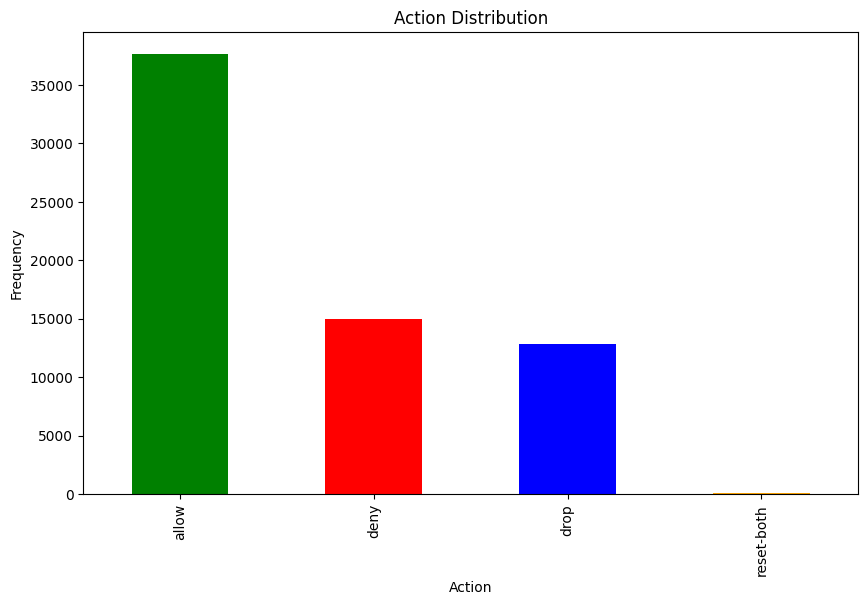

In [10]:
# Action Distribution
plt.figure(figsize=(10, 6))
data['Action'].value_counts().plot(kind='bar', color=['green', 'red', 'blue', 'orange'])
plt.title("Action Distribution")
plt.xlabel("Action")
plt.ylabel("Frequency")
# Save the plot
plt.savefig('Action Distribution.png')
plt.show()

The purpose of this graph is to visualize the distribution of actions (Action) in the dataset. By creating a count plot, we can quickly understand how often each action (e.g. "allow","deny","drop" or "reset-both") occurs.

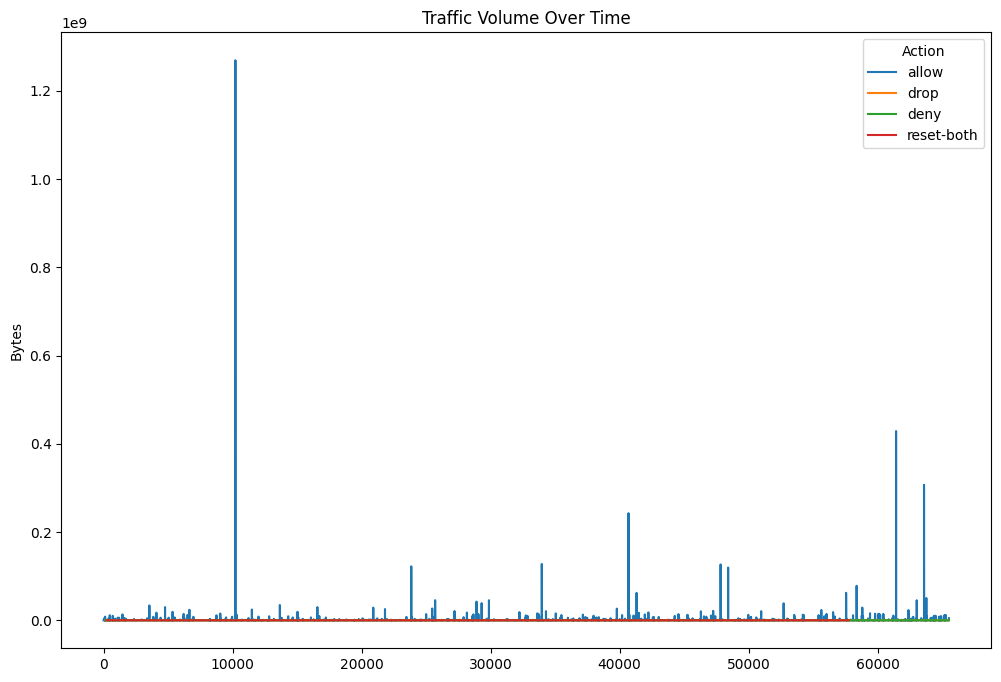

In [11]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed (width, height)

# Traffic over time
sns.lineplot(data=data, x=data.index, y='Bytes', hue='Action')
plt.title('Traffic Volume Over Time')
plt.savefig('Traffic Volume Over Time.png')
plt.show()

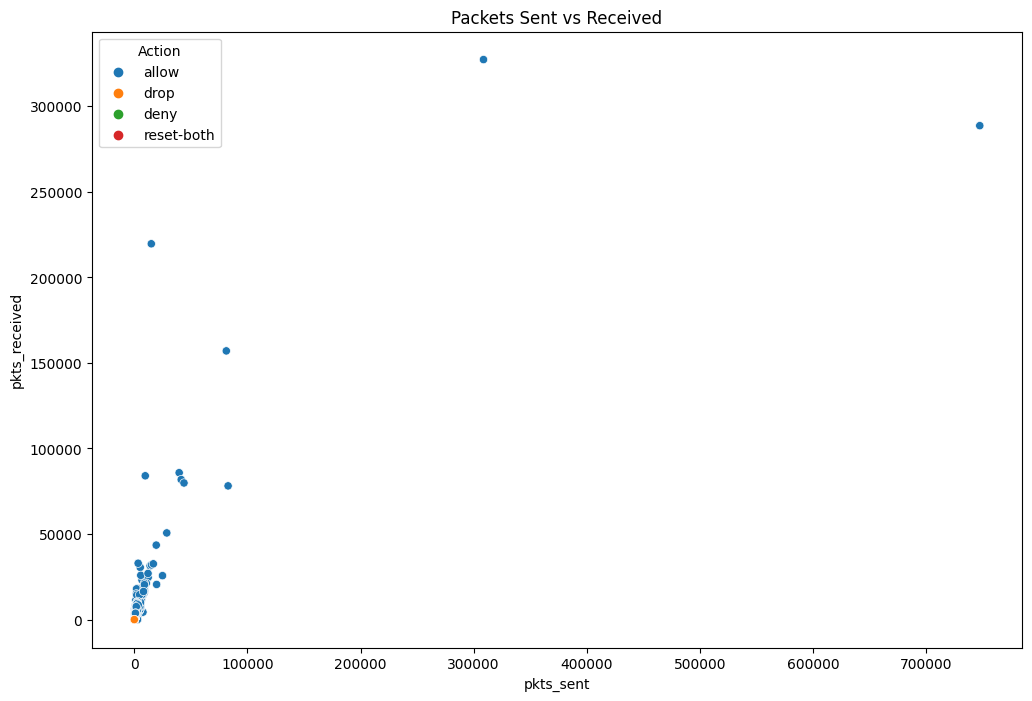

In [12]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed (width, height)

# Packet analysis
sns.scatterplot(data=data, x='pkts_sent', y='pkts_received', hue='Action')
plt.title('Packets Sent vs Received')
plt.savefig('Packets Sent vs Received.png')
plt.show()

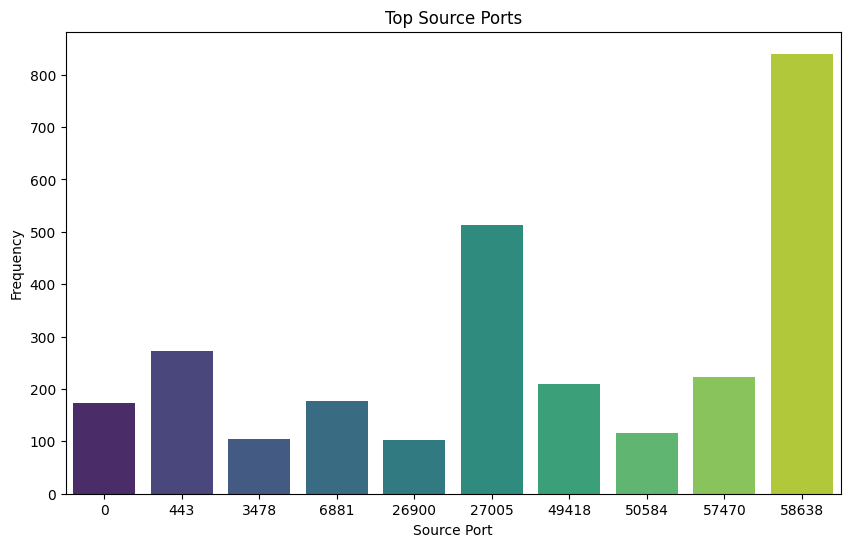

In [13]:
# Top Source Ports
plt.figure(figsize=(10, 6))
top_src_ports = data['Source Port'].value_counts().head(10)
sns.barplot(x=top_src_ports.index, y=top_src_ports.values, palette='viridis')
plt.title("Top Source Ports")
plt.xlabel("Source Port")
plt.ylabel("Frequency")
plt.savefig('Top Source Ports.png')
plt.show()

## Observations from the data

# 1. Action: "Allow"
#    - Scenario 1: Bytes sent and received are nearly equal, with pkts_sent and pkts_received also equal.
#    - Scenario 2: Bytes sent and received differ, with pkts_sent and pkts_received close but not equal.

# 2. Action: "Deny"
#    - Scenario 1: Bytes sent is non-zero, but bytes received is zero; pkts_sent is 1, and pkts_received is 0.
#    - Scenario 2: Bytes sent and received differ, with pkts_sent and pkts_received being equal.

# 3. Action: "Drop"
#    - Bytes sent is non-zero, but bytes received is zero; pkts_sent is 1, and pkts_received is 0.

# 4. Action: "Reset-Both"
#    - Scenario 1: Bytes sent is non-zero, but bytes received is zero; pkts_sent is 1, and pkts_received is 0.
#    - Scenario 2: Bytes sent and received differ, with pkts_sent greater than pkts_received.

# These observations highlight patterns in packet transmission for different actions,
# which could be useful for identifying trends or anomalies in the data.


In [14]:
data1 = data.copy()

In [15]:
data1

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


## Feature Engineering

## Converting Elapsed Time to Timestamps

### Overview
The dataset contains a column named `Elapsed Time (sec)` that represents the time elapsed in seconds since a specific reference point. The goal is to create a new column, `Timestamp`, by converting the elapsed seconds into datetime values.


In [16]:

# Assuming Elapsed Time is in seconds since a fixed reference point (e.g., Unix Epoch)
# Define the reference point (adjust as per your dataset context)
reference_point = pd.Timestamp("2024-01-01 00:00:00")  

# Convert elapsed seconds to timestamps
data1['Timestamp'] = reference_point + pd.to_timedelta(data1['Elapsed Time (sec)'], unit='s')


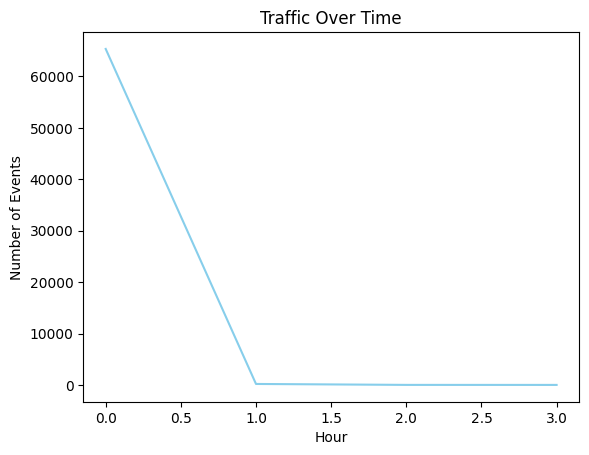

In [18]:
# # Traffic Over Time
# if 'Timestamp' in data.columns:
data1['hour'] = pd.to_datetime(data1['Timestamp']).dt.hour
hourly_traffic = data1.groupby('hour').size()
hourly_traffic.plot(kind='line', color='skyblue')
plt.title("Traffic Over Time")
plt.xlabel("Hour")
plt.ylabel("Number of Events")
plt.savefig('Traffic over time.png')
plt.show()

# Hours Summary

In [19]:
# Define 'time_frame' variable with a valid value, such as "Hourly", "12 Hours", or others
time_frame = "Hourly"  # Replace with the desired time frame

if time_frame == "Hourly":
    summary = data1.groupby('hour')[['Bytes', 'Packets']].sum()
elif time_frame == "12 Hours":
    data1['12_hour'] = pd.cut(data1['hour'], bins=[0, 12, 24], labels=['0-12', '12-24'], right=False)
    summary = data1.groupby('12_hour')[['Bytes', 'Packets']].sum()
else:  # 24 Hours
    summary = data1[['Bytes', 'Packets']].sum().to_frame(name="Total").T

print(summary)

           Bytes  Packets
hour                     
0     4475545026  5088549
1      619605475   614770
2     1269432469  1036592
3         143727     1106


# Error Insights

## Identifying and Counting Specific Errors


The goal is to filter rows in the dataset where the `Action` column contains specific error values (`'drop'` or `'deny'`) and calculate the total number of such errors.


In [20]:
errors = data1[data1['Action'].isin(['drop', 'deny'])]
print(f"Total Errors: {len(errors)}")

Total Errors: 27838


# Total Errors: 27838

#  Traffic Patterns

## Calculating Average Packet Size

The goal is to compute the average packet size for both sent and received data in the dataset. This is achieved by dividing the total bytes by the number of packets sent or received.


In [21]:
data1['Avg Packet Size Sent'] = data1['Bytes Sent'] / (data1['pkts_sent'] + 1e-6)
data1['Avg Packet Size Received'] = data1['Bytes Received'] / (data1['pkts_received'] + 1e-6)

## Rate Calculations

### Traffic Rate (Bytes/sec)
To calculate the **Traffic Rate** in bytes per second for each row in the dataset. The traffic rate is derived by dividing the total bytes by the elapsed time in seconds.


In [22]:
data1['Traffic Rate'] = data1['Bytes'] / (data1['Elapsed Time (sec)'] + 1e-6)

## Rate Calculations

### Packet Rate (Packets/sec)
To calculate the **Packet Rate** in packets per second for each row in the dataset. This is achieved by dividing the total number of packets by the elapsed time in seconds.


In [23]:
data1['Packet Rate'] = data1['Packets'] / (data1['Elapsed Time (sec)'] + 1e-6)

In [24]:
data1['Action'].astype(str)

0        allow
1        allow
2        allow
3        allow
4        allow
         ...  
65527    allow
65528    allow
65529     drop
65530     drop
65531     drop
Name: Action, Length: 65532, dtype: object

## Action Encoding

### Mapping Actions to Numerical Values

To encode the categorical values in the `Action` column into numerical values for easier analysis or use in machine learning models.


In [25]:
action_mapping = {'drop': 0, 'deny': 1, 'allow': 2, 'reset-both': 3}
data1['action_encoded'] = data1['Action'].map(action_mapping)

# Calculating Bytes Imbalance and Imbalance Percentage

To measure the difference between bytes sent and received for each row in the dataset, both in absolute terms and as a percentage of total bytes.

In [26]:
data1['Bytes Imbalance'] = data1['Bytes Sent'] - data1['Bytes Received']
data1['Bytes Imbalance (%)'] = (abs(data1['Bytes Sent'] - data1['Bytes Received']) / data1['Bytes']) * 100

# Show the distribution of Bytes Imbalance (%)

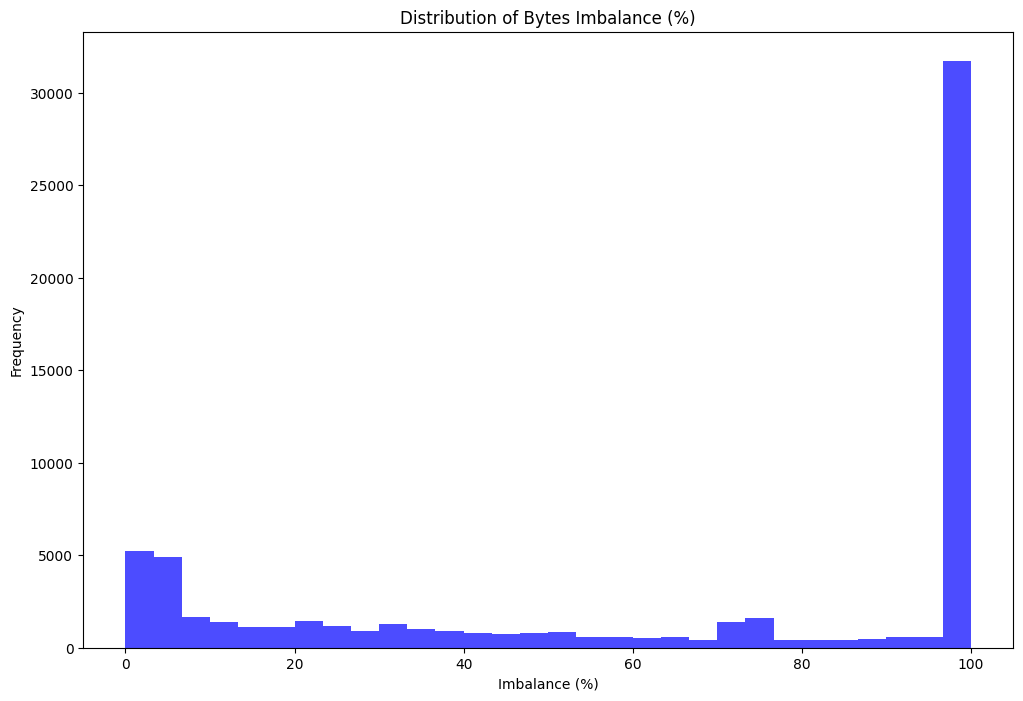

In [27]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed (width, height)

# Histogram
plt.hist(data1['Bytes Imbalance (%)'], bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Bytes Imbalance (%)")
plt.xlabel("Imbalance (%)")
plt.ylabel("Frequency")
plt.savefig('Distribution of Bytes Imbalance (%).png')
plt.show()

# Unexpected Traffic Spikes

In [28]:
traffic_mean = data1['Traffic Rate'].mean()
traffic_std = data1['Traffic Rate'].std()
spikes = data1[data1['Traffic Rate'] > (traffic_mean + 3 * traffic_std)]
print(f"Total Traffic Spikes Detected: {len(spikes)}")

Total Traffic Spikes Detected: 508


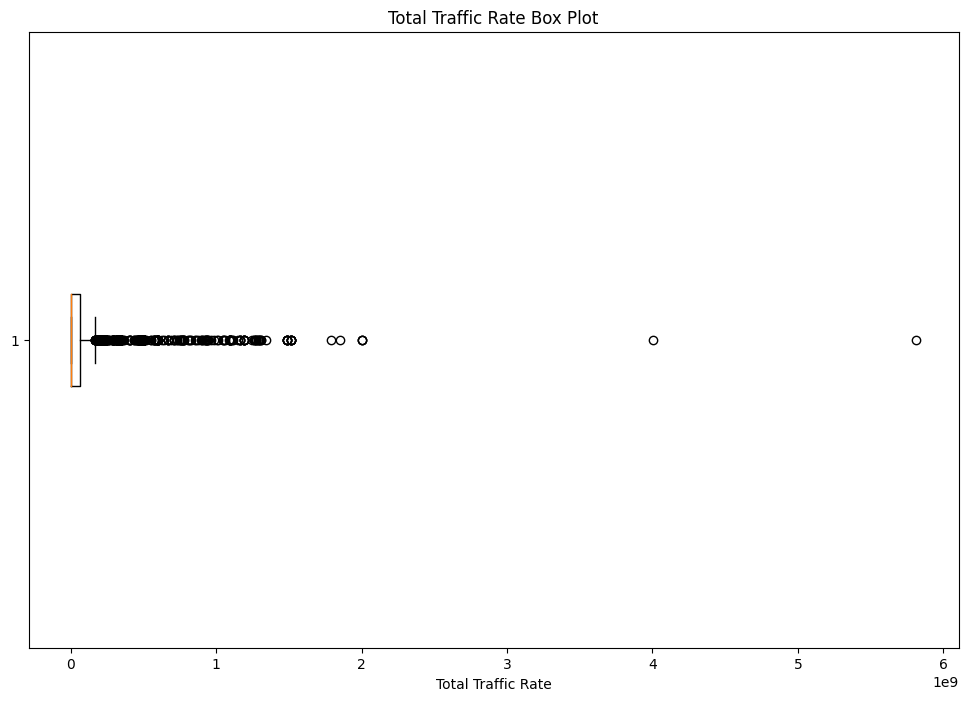

In [29]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Box plot
plt.boxplot(data1['Traffic Rate'], vert=False)
plt.title("Total Traffic Rate Box Plot")
plt.xlabel("Total Traffic Rate")
plt.savefig('Total Traffic Rate Box Plot.png')
plt.show()


## Detecting Spikes in Packet Count

To identify rows in the dataset where the number of packets exceeds a defined threshold, indicating potential spikes in traffic.


In [81]:
# Detect spikes
packet_threshold = data1['Packets'].mean() + 3 * data1['Packets'].std()
spike_rows = data1[data1['Packets'] > packet_threshold]

print(f"Number of spikes: {len(spike_rows)}")


Number of spikes: 49


Plot Total Packets against Elapsed Time (sec) or any other time dimension to visually identify spikes.

Identify outliers in Total Packets.

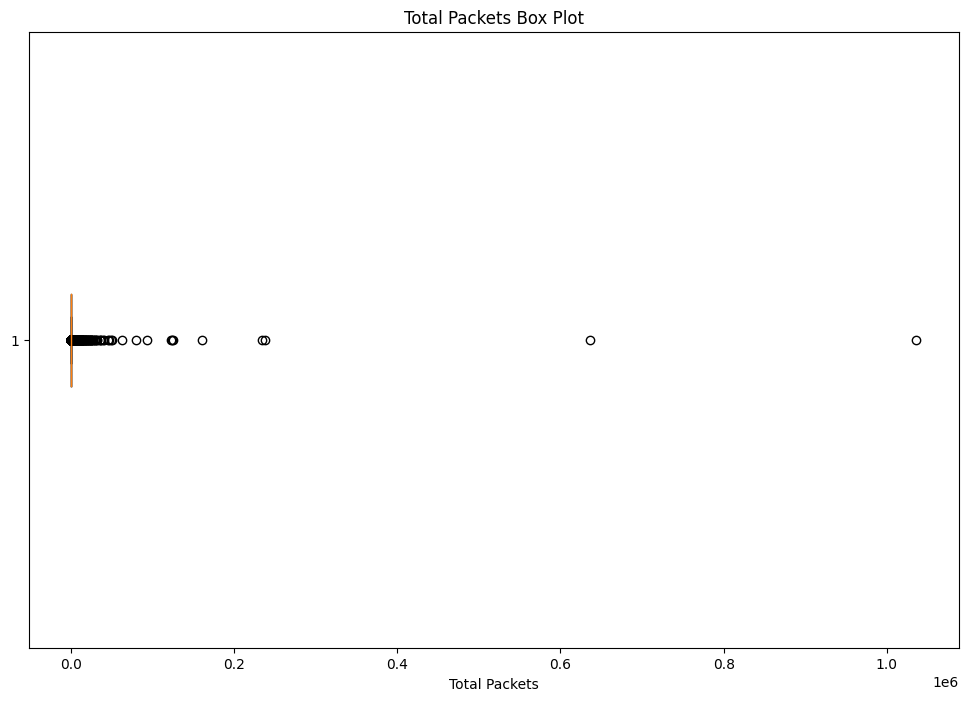

In [31]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Box plot
plt.boxplot(data1['Packets'], vert=False)
plt.title("Total Packets Box Plot")
plt.xlabel("Total Packets")
plt.savefig('Total Packets Box Plot.png')
plt.show()


## Calculate Packet Ratio

To compute the ratio of packets sent to packets received for each row in the dataset, helping analyze the balance between outgoing and incoming network traffic.

In [32]:
# Calculate packet ratio
data1['Packet Ratio'] = data1['pkts_sent'] / (data1['pkts_received'] + 1e-6)  # Avoid division by zero

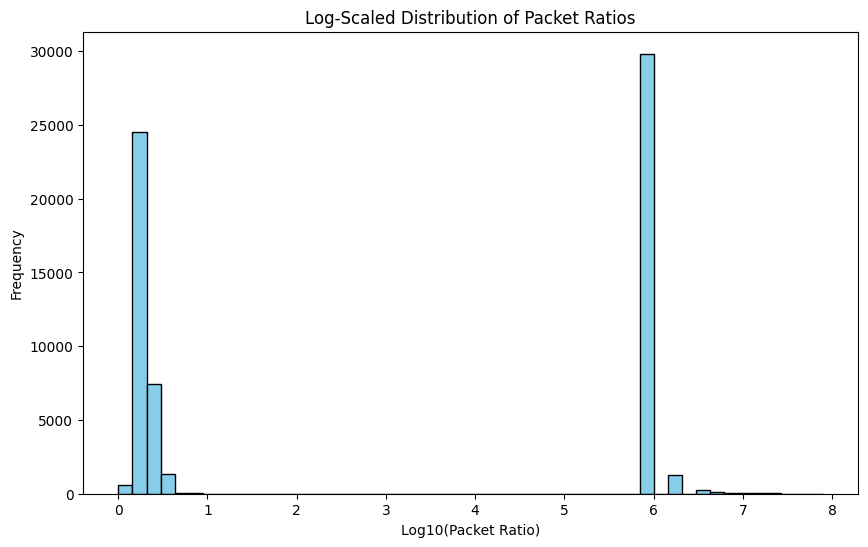

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(np.log10(data1['Packet Ratio'] + 1), bins=50, color='skyblue', edgecolor='black')
plt.title('Log-Scaled Distribution of Packet Ratios')
plt.xlabel('Log10(Packet Ratio)')
plt.ylabel('Frequency')
plt.savefig('Log-Scaled Distribution of Packet Ratios.png')
plt.show()


## Calculate Logarithmic Packet Ratio

To compute the natural logarithm of the packet ratio plus one (`log(1 + Packet Ratio)`) for each row in the dataset. This transformation helps normalize the data, particularly when the `Packet Ratio` values vary widely.


In [82]:
data1['Log Packet Ratio'] = np.log1p(data1['Packet Ratio'])

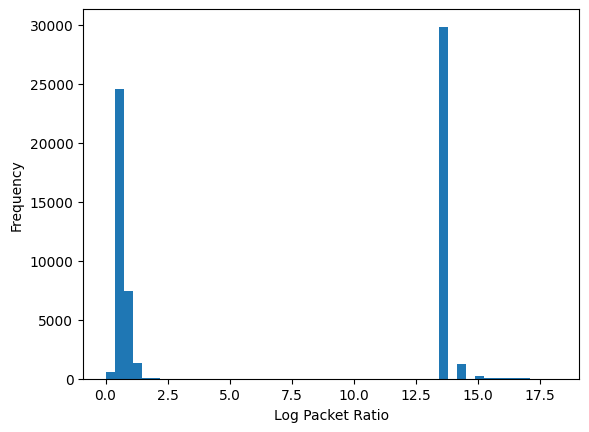

In [83]:
import matplotlib.pyplot as plt
plt.hist(data1['Log Packet Ratio'], bins=50)
plt.xlabel('Log Packet Ratio')
plt.ylabel('Frequency')
plt.savefig('Log Packet Ratio.png')
plt.show()


# Classifying Log Packet Ratio

To classify the **Log Packet Ratio** into different categories based on predefined thresholds. This classification helps in evaluating the network traffic behavior and identifying critical or unusual patterns.

Based on general network patterns:

**Small Discrepancies (Acceptable)**:

Define the range where communication is normal and balanced.
Range: Log Packet Ratio ≈ 0 to 2
(covers most of the normal traffic).

**Moderate Discrepancies (Warning)**:

Define the range where discrepancies start becoming noticeable but not yet critical.
Range: Log Packet Ratio ≈ 2 to 12

**Critical Anomalies (Actionable)**:

Define the range where the discrepancies are extreme and likely indicate significant issues.
Range: Log Packet Ratio > 12

In [84]:
def classify_log_packet_ratio(log_ratio):
    if log_ratio < 2:
        return 'Acceptable'
    elif 2 <= log_ratio <= 12:
        return 'Warning'
    else:
        return 'Critical'

data1['Log Packet Ratio Label'] = data1['Log Packet Ratio'].apply(classify_log_packet_ratio)


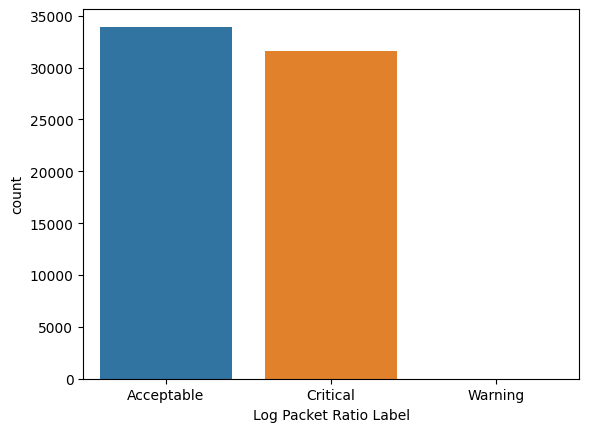

In [85]:
import seaborn as sns
sns.countplot(data=data1, x='Log Packet Ratio Label')
# Save the plot using plt.savefig
plt.savefig("Log Packet Ratio Label.png")


# Detecting Rare IP Activity: Source and Destination Ports

To identify the **rare** source and destination ports based on their occurrence in the dataset. Rare ports can indicate unusual or suspicious traffic patterns.


In [38]:
rare_sources = data1['Source Port'].value_counts().nsmallest(5)
print(f"Rare Source Ports:  \n {rare_sources}")

rare_destinations = data1['Destination Port'].value_counts().nsmallest(5)
print(f"Rare Destination Ports: \n  {rare_destinations}")

Rare Source Ports:  
 54871    1
36887    1
1939     1
1940     1
38802    1
Name: Source Port, dtype: int64
Rare Destination Ports: 
  22455    1
12502    1
42671    1
63425    1
25161    1
Name: Destination Port, dtype: int64


 # Anomaly Detection

# Anomaly Detection with Isolation Forest

To detect anomalies in network traffic data using the **Isolation Forest** algorithm. Anomalies are flagged where the data points deviate significantly from the rest of the dataset.


In [39]:
# Define Features
features =  ['Source Port', 'Destination Port', 'Traffic Rate', 'Packet Rate', 'Log Packet Ratio']
X = data1[features]

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
data1['anomaly'] = model.fit_predict(X)

# Mark Anomalies
anomalies = data1[data1['anomaly'] == -1]
print(f"Number of anomalies: {len(anomalies)}")

/home/dataai/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies: 3277


# Number of anomalies: 3277

In [40]:
data1.to_csv('output.csv', index=False)

## ML Approach 1 : Machine Learning for Anomaly Detection

The goal of this approach is to classify network traffic data as either normal or anomalous by identifying **Critical** and **Warning** traffic patterns. This allows for the simplification of anomaly categories and facilitates easy interpretation of results, enabling effective detection and alerting when anomalies occur.

In [41]:
main_training_dataset = data1.copy()

In [42]:
# Combine Critical and Warning into one category as '1'
main_training_dataset['Anomaly_Label'] = main_training_dataset['Log Packet Ratio Label'].apply(lambda x: 1 if x in ['Critical', 'Warning'] else 0)

In [43]:
main_training_dataset.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),...,Traffic Rate,Packet Rate,action_encoded,Bytes Imbalance,Bytes Imbalance (%),Packet Ratio,Log Packet Ratio,Log Packet Ratio Label,anomaly,Anomaly_Label
0,57222,53,54587,53,allow,177,94,83,2,30,...,5.900000,0.066667,2,11,6.214689,0.999999,0.693147,Acceptable,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,...,280.470572,1.117647,2,-1568,32.885906,1.111111,0.747214,Acceptable,1,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,...,0.198499,0.001668,2,-2,0.840336,0.999999,0.693147,Acceptable,-1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,...,195.705871,0.882353,2,-451,13.555756,1.142857,0.762140,Acceptable,1,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,...,1584.874901,1.937500,2,-11802,46.541525,0.722222,0.543615,Acceptable,1,0


In [44]:
main_training_dataset['Anomaly_Label'].value_counts()

0    33940
1    31592
Name: Anomaly_Label, dtype: int64

# Train the model

In [57]:
# Features and labels
# Prepare Data
X = main_training_dataset[[
    'Bytes',
'Bytes Sent',
'Bytes Received',
'Packets'	,
'Elapsed Time (sec)',
'pkts_sent',
'pkts_received',
'action_encoded']]

y = main_training_dataset['Anomaly_Label']

In [58]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Train model with class weights
clf = RandomForestClassifier(random_state=42)

In [60]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluation Summary

In [61]:
# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [62]:
# 2. Precision, Recall, and F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6780
           1       1.00      1.00      1.00      6327

    accuracy                           1.00     13107
   macro avg       1.00      1.00      1.00     13107
weighted avg       1.00      1.00      1.00     13107



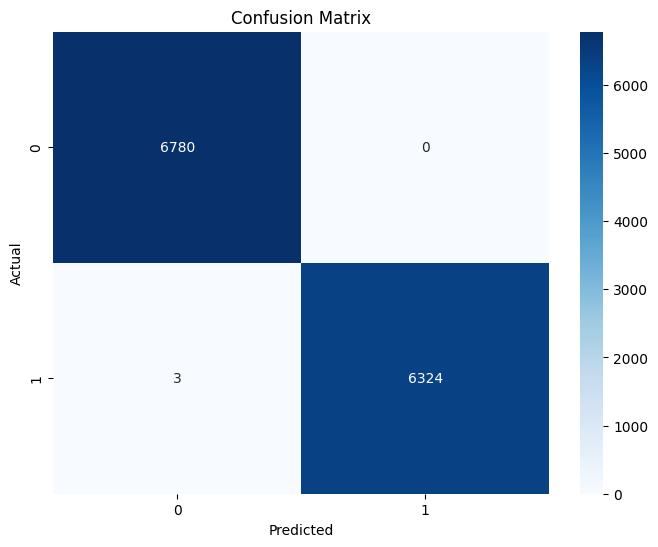

In [63]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix Approach1.png")
plt.show()


### Conclusion

This machine learning approach successfully classifies network traffic into normal and anomalous categories. The model demonstrates excellent performance with 100% accuracy, and the results can be used to alert when network behavior deviates from the expected patterns. By simplifying the categories into a binary classification (normal vs. anomalous), the model's predictions are easy to interpret and act upon, making it a powerful tool for anomaly detection in network traffic analysis.



## ML Approach 2 : Machine Learning with Class Imbalance Handling

The second approach aims to identify normal behavior and anomalies (critical/warning) in network traffic data, similar to the first approach, but with additional handling for class imbalance. This is achieved by computing class weights to give more importance to the less frequent class (anomalous traffic), improving the model's performance in detecting anomalies.


In [64]:
main_training_dataset = data1.copy()

In [65]:
# Combine Critical and Warning into one category as '1'
main_training_dataset['Anomaly_Label'] = main_training_dataset['Log Packet Ratio Label'].apply(lambda x: 1 if x in ['Critical', 'Warning'] else 0)

In [66]:


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Convert classes to a NumPy array
    y=main_training_dataset['Anomaly_Label']
)

# Convert to dictionary
weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights:", weights_dict)


Class Weights: {0: 0.9654095462581025, 1: 1.037161306659914}


In [67]:
# Features and labels

X = main_training_dataset[[
    'Bytes',
'Bytes Sent',
'Bytes Received',
'Packets'	,
'Elapsed Time (sec)',
'pkts_sent',
'pkts_received',
'action_encoded']]

y = main_training_dataset['Anomaly_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with class weights
clf = RandomForestClassifier(class_weight=weights_dict,random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.9654095462581025,
                                     1: 1.037161306659914},
                       random_state=42)

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6780
           1       1.00      1.00      1.00      6327

    accuracy                           1.00     13107
   macro avg       1.00      1.00      1.00     13107
weighted avg       1.00      1.00      1.00     13107



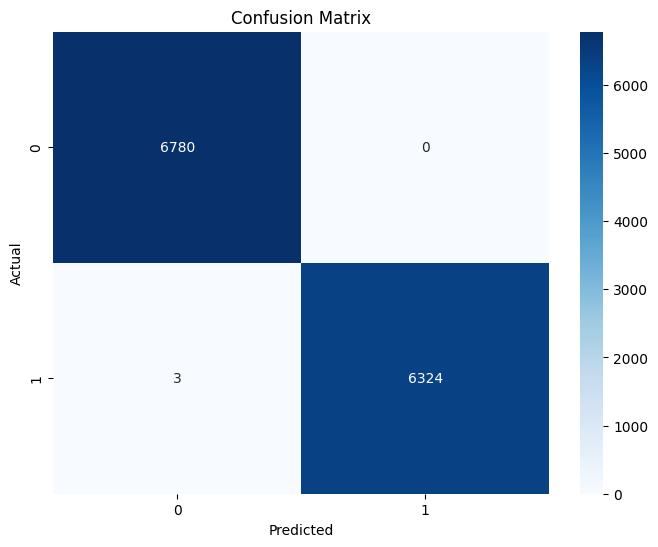

In [68]:

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 2. Precision, Recall, and F1-Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix Approach2.png")
plt.show()

### Conclusion

This approach improves upon the first by incorporating class weight adjustments to handle imbalanced datasets. Despite the potential imbalance between normal and anomalous traffic, the model achieved perfect accuracy and classification metrics, ensuring reliable anomaly detection in network traffic. The class weight adjustment makes the model more robust, enhancing its ability to detect rare anomalous events.


## ML Approach 3 : Multi-Class Classification with Class Weight Handling

The third approach aims to classify network traffic data into three categories: **Acceptable**, **Critical**, and **Warning**. The model incorporates class weight adjustments to handle the imbalance in the distribution of traffic labels. The **Warning** category is highly underrepresented, and handling this imbalance helps improve the model's ability to classify anomalies.


In [69]:
main_multi_training_dataset = data1.copy()

In [70]:
main_multi_training_dataset['Log Packet Ratio Label'].value_counts()

Acceptable    33940
Critical      31574
Warning          18
Name: Log Packet Ratio Label, dtype: int64

In [71]:
# Encode categorical labels across the entire dataset
label_encoder = LabelEncoder()
main_multi_training_dataset['Encoded_Label'] = label_encoder.fit_transform(main_multi_training_dataset['Log Packet Ratio Label'])

In [72]:
main_multi_training_dataset.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),...,Traffic Rate,Packet Rate,action_encoded,Bytes Imbalance,Bytes Imbalance (%),Packet Ratio,Log Packet Ratio,Log Packet Ratio Label,anomaly,Encoded_Label
0,57222,53,54587,53,allow,177,94,83,2,30,...,5.900000,0.066667,2,11,6.214689,0.999999,0.693147,Acceptable,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,...,280.470572,1.117647,2,-1568,32.885906,1.111111,0.747214,Acceptable,1,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,...,0.198499,0.001668,2,-2,0.840336,0.999999,0.693147,Acceptable,-1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,...,195.705871,0.882353,2,-451,13.555756,1.142857,0.762140,Acceptable,1,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,...,1584.874901,1.937500,2,-11802,46.541525,0.722222,0.543615,Acceptable,1,0


In [73]:
# Split features and target

X = main_multi_training_dataset[[
    'Bytes',
'Bytes Sent',
'Bytes Received',
'Packets'	,
'Elapsed Time (sec)',
'pkts_sent',
'pkts_received',
'action_encoded']]

y = main_multi_training_dataset['Encoded_Label']

# Split into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical classes for class weights
encoded_classes = np.unique(y)  # Use the entire encoded target variable

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=encoded_classes,
    y=y  # Use the entire encoded target variable
)

# Create a dictionary mapping encoded classes to their weights
weights_dict = dict(zip(encoded_classes, class_weights))
print("Class Weights:", weights_dict)

# Train RandomForestClassifier with class weights
clf = RandomForestClassifier(class_weight=weights_dict, random_state=42)
clf.fit(X_train, y_train)


Class Weights: {0: 0.6436063641720684, 1: 0.6918350541584848, 2: 1213.5555555555557}


RandomForestClassifier(class_weight={0: 0.6436063641720684,
                                     1: 0.6918350541584848,
                                     2: 1213.5555555555557},
                       random_state=42)

In [74]:
# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [75]:
# Predict on test set
predictions = clf.predict(X_test)

# Decode predictions back to original labels
decoded_predictions = label_encoder.inverse_transform(predictions)

# Evaluate model

print(classification_report(y_test, predictions, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

  Acceptable       1.00      1.00      1.00      6780
    Critical       1.00      1.00      1.00      6321
     Warning       1.00      0.33      0.50         6

    accuracy                           1.00     13107
   macro avg       1.00      0.78      0.83     13107
weighted avg       1.00      1.00      1.00     13107



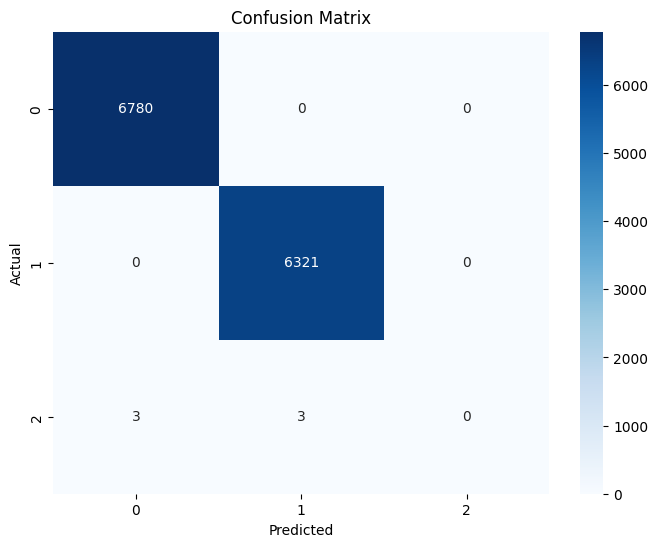

In [77]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix Approach3.png")
plt.show()

### Conclusion

In this approach, the model achieved perfect accuracy and classification for most traffic categories. However, due to the extremely low number of **Warning** samples, the recall for this category is significantly lower. The class weight handling helped to account for the class imbalance, improving the detection of rare classes, but the low number of **Warning** instances made it challenging to predict this category effectively. Despite this, the model showed robust performance in detecting **Acceptable** and **Critical** traffic.
